<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AT-dinucleotide-repeats-affect-read-depth" data-toc-modified-id="AT-dinucleotide-repeats-affect-read-depth-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AT dinucleotide repeats affect read depth</a></span></li><li><span><a href="#Prepare-training-and-testing-data" data-toc-modified-id="Prepare-training-and-testing-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare training and testing data</a></span></li><li><span><a href="#Code-to-train-and-evaluate-models" data-toc-modified-id="Code-to-train-and-evaluate-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Code to train and evaluate models</a></span></li><li><span><a href="#Baseline-model" data-toc-modified-id="Baseline-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Baseline model</a></span></li><li><span><a href="#Additional-filters-and-additional-dropout" data-toc-modified-id="Additional-filters-and-additional-dropout-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Additional filters and additional dropout</a></span></li><li><span><a href="#Smaller-learning-rate" data-toc-modified-id="Smaller-learning-rate-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Smaller learning rate</a></span></li><li><span><a href="#Add-pooling" data-toc-modified-id="Add-pooling-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Add pooling</a></span></li><li><span><a href="#Add-strong-L2-regularization" data-toc-modified-id="Add-strong-L2-regularization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add strong L2 regularization</a></span></li><li><span><a href="#Add-weak-L2-regularization" data-toc-modified-id="Add-weak-L2-regularization-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Add weak L2 regularization</a></span></li><li><span><a href="#Larger-number-of-Poisson-components" data-toc-modified-id="Larger-number-of-Poisson-components-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Larger number of Poisson components</a></span></li><li><span><a href="#model-4:-increase-dropout-rate-and-add-weak-L2-regularization" data-toc-modified-id="model-4:-increase-dropout-rate-and-add-weak-L2-regularization-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>model 4: increase dropout rate and add weak L2 regularization</a></span></li><li><span><a href="#Batch-normalization" data-toc-modified-id="Batch-normalization-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Batch normalization</a></span></li><li><span><a href="#To-Do" data-toc-modified-id="To-Do-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>To Do</a></span></li></ul></div>

## AT dinucleotide repeats affect read depth

[Ross et al 2013](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2013-14-5-r51) (Table 2) and [Smith et al 2015](https://peerj.com/articles/836/) (Fig 3) established that sequences containing AT dinucleotide repeats tend to have lower read depths than random sequences. Let's check to see if that is the case in the CEPH data set. 

First, generate a set of positive examples, containing AT dinucleotide repeats, and a set of negative examples, chosen randomly from chromosome 22. Then, compare the distributions of read depths, conditioned upon whether the sequence contains the AT-dinucleotide-repeat motif or not: 

In [1]:
from Bio import SeqIO
import re
from load_preprocess_data import read_depths, _add_sequences
from utility import named_tuple
import pandas as pd 
from collections import OrderedDict
import numpy as np 

def create_positive_examples(pattern, sequence_length, chromosome_number, chromosome, depths): 
    starts = []
    ends = []
    centers = []
    sequences = []
    observed_depths = []
    # use regex lookahead to find overlapping matches: 
    # Based upon steve's answer at https://www.biostars.org/p/209383/
    for match in re.finditer('(?={})'.format(pattern), chromosome):
        padding_left = (sequence_length - len(pattern))//2
        padding_right = sequence_length - len(pattern) - padding_left
        start = match.start() - padding_left
        end = match.start() + len(pattern) + padding_right
        starts.append(start)
        ends.append(end)
        center = start + sequence_length//2
        centers.append(center)
        sequences.append(chromosome[start:end])
        observed_depths.append(depths[center])

    return pd.DataFrame(OrderedDict([('chromosome_number', chromosome_number),
                                     ('start', starts),
                                     ('center', centers),
                                     ('end', ends),
                                     ('sequence', sequences),
                                     ('observed_depth', observed_depths)]))

def create_negative_examples(sequence_length, chromosome_number, chromosome, depths, size, 
                             a=20000000, b=50000000): 
    # negative examples are unlikely to coincide with positive examples, 
    # since the latter are so rare
    starts = np.random.choice(np.arange(a, b-sequence_length+1),
                              size=size,
                              replace=False)
    ends = starts + sequence_length
    centers = starts + sequence_length//2
    observed_depths = depths[centers]

    data = pd.DataFrame(OrderedDict([('chromosome_number', chromosome_number),
                                     ('start', starts),
                                     ('center', centers),
                                     ('end', ends),
                                     ('observed_depth', observed_depths)]))
        
    return _add_sequences(data, chromosome).sort_values('start')

def create_examples(pattern, 
                    sequence_length,   
                    depth_file,
                    fasta_file='../data/sequences/human_g1k_v37.fasta'):
    for record in SeqIO.parse(fasta_file, 'fasta'):
        chromosome_number = record.id
        if chromosome_number != '22': 
            continue
        chromosome = str(record.seq)
        args = named_tuple({'chromosome_number': int(chromosome_number), 
                            'depth_file_name': depth_file})
        depths = read_depths(args)
        
        assert(len(pattern) < sequence_length)
        _positive_examples = create_positive_examples(pattern, sequence_length, chromosome_number, chromosome, depths)    
        _negative_examples = create_negative_examples(sequence_length, chromosome_number, chromosome, depths, size=len(_positive_examples))

        return _positive_examples, _negative_examples, pattern

import matplotlib.pyplot as plt
%matplotlib inline 

def _plot_read_depth_distribution(_positive_examples, _negative_examples, _dinucleotide): 
    mean_depth = np.mean(_negative_examples['observed_depth']) 

    plt.figure(figsize=(10,5))    
    bins = np.linspace(0, 3, 100)
    plt.hist(_positive_examples['observed_depth']/mean_depth, bins, alpha=0.5, label='positive examples')
    plt.hist(_negative_examples['observed_depth']/mean_depth, bins, alpha=0.5, label='negative examples')
    
    def compute_model_depths(examples):         
        return np.random.poisson(
            lam=np.mean(examples['observed_depth']),
            size=len(examples)
        )
    
    plt.hist(compute_model_depths(_positive_examples)/mean_depth, bins, alpha=0.5, label='positive examples (pure poisson model)')
    plt.hist(compute_model_depths(_negative_examples)/mean_depth, bins, alpha=0.5, label='negative examples (pure poisson model)')

    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('linear')
    _ = plt.title('mean depth: {:.1f}'.format(mean_depth) + '  dinucleotide: ({}){}'.format(_dinucleotide[:2], len(_dinucleotide)//2))
    
def plot_read_depth_distribution(pattern, depth_file='../data/depths/100.multicov.int32.bin'):
    _plot_read_depth_distribution(*create_examples(pattern=pattern, sequence_length=50, depth_file=depth_file))    
    
AT2 = 'ATAT'
AT5 = 'ATATATATAT'    
AT10 = 'ATATATATATATATATATAT'
AT15 = 'ATATATATATATATATATATATATATATAT'
AT20 = 'ATATATATATATATATATATATATATATATATATATATAT'

AA10 = 'AAAAAAAAAAAAAAAAAAAA'
TT10 = 'TTTTTTTTTTTTTTTTTTTT'



First, let's demonstrate that the signal-to-noise ratio is maximal when the mean depth is largest: 

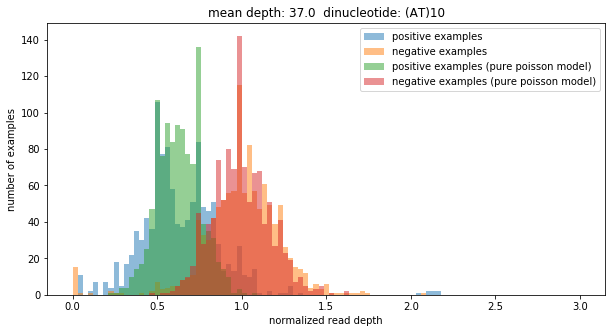

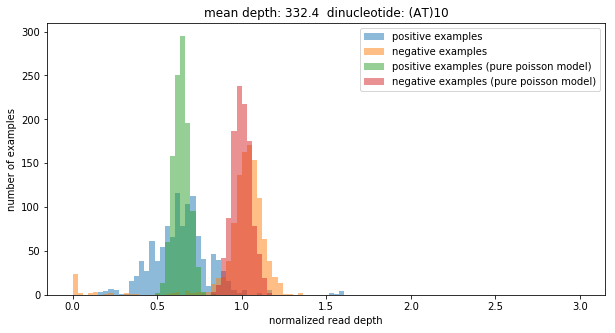

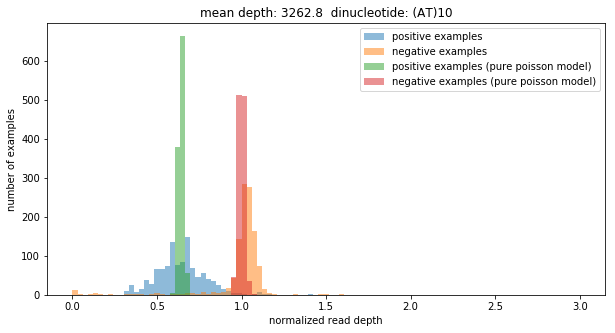

In [2]:
plot_read_depth_distribution(pattern=AT10, depth_file='../data/depths/1.multicov.int32.bin')
plot_read_depth_distribution(pattern=AT10, depth_file='../data/depths/10.multicov.int32.bin')
plot_read_depth_distribution(pattern=AT10, depth_file='../data/depths/100.multicov.int32.bin')

Next, let's find the optimal motif length: 

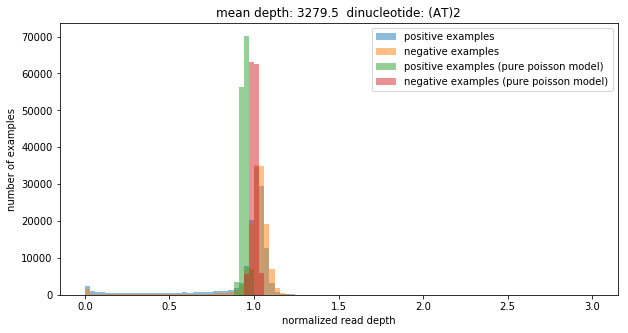

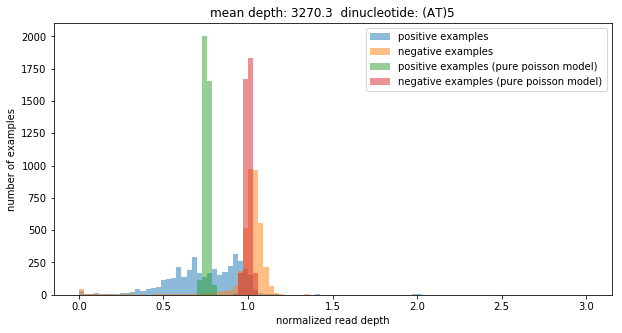

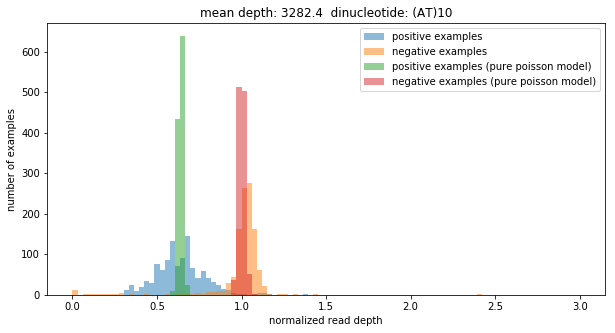

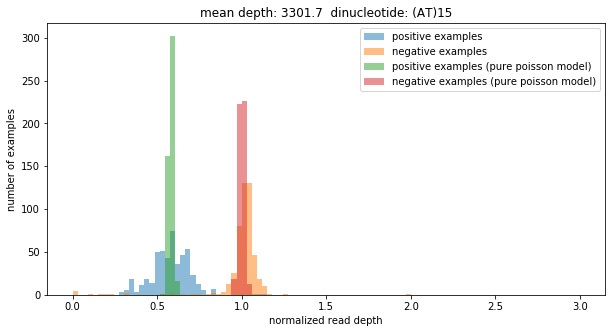

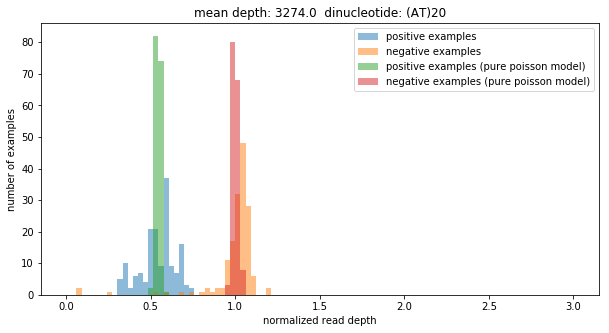

In [3]:
plot_read_depth_distribution(AT2)
plot_read_depth_distribution(AT5)
plot_read_depth_distribution(AT10)
plot_read_depth_distribution(AT15)
plot_read_depth_distribution(AT20)


A motif consisting of 10 dinucleotide repeats seems to be a decent trade-off between (i) having a significant difference of read depth between positive and negative examples and (ii) having enough examples of the positive class. 

## Prepare training and testing data 

Let's create a data set to train and test a deep-learning model:

In [4]:
def build_data_frame(depth_file='../data/depths/100.multicov.int32.bin'): 
    positive_examples, negative_examples, dinucleotide = create_examples(pattern=AT10, sequence_length=30, depth_file=depth_file)
    
    negative_examples['class'] = 0
    positive_examples['class'] = 1

    df = pd.concat([negative_examples, positive_examples], ignore_index=True, sort=False)

    # shuffle data
    return df.sample(frac=1) 

def build_data_frames():
    df = build_data_frame()

    # split data
    test_dev_sets_size = min(1000, int(0.1*len(df)))

    # make copies to avoid settingwithcopywarning: https://www.dataquest.io/blog/settingwithcopywarning
    df_test = df[:test_dev_sets_size].copy()
    df_dev = df[test_dev_sets_size:2*test_dev_sets_size].copy()
    df_train = df[2*test_dev_sets_size:].copy()
    
    return df_test, df_dev, df_train


In [2]:

data_test, data_dev, data_train = build_data_frames()

data_test.to_pickle('./test.pkl')
data_dev.to_pickle('./dev.pkl')
data_train.to_pickle('./train.pkl')



In [1]:
import pandas as pd
data_test = pd.read_pickle('./test.pkl')
data_dev = pd.read_pickle('./dev.pkl')
data_train = pd.read_pickle('./train.pkl')


## Code to train and evaluate models

In [12]:
from tensorflow.keras.backend import clear_session
import tensorflow as tf 
import tensorflow_probability as tfp 

from tensorflow import enable_eager_execution
enable_eager_execution()

import numpy as np 

def compute_sequence_length(df):
    return np.float32(len(df['sequence'].iloc[0])) # casting circumvents nan loss 

from load_preprocess_data import _preprocess_conv1d
from tensorflow.keras.callbacks import Callback
tfd = tfp.distributions

class CustomHistory(Callback):
    def __init__(self, data_train_, data_dev_, data_test_):
        self.data_train_ = data_train_
        self.data_dev_ = data_dev_
        self.data_test_ = data_test_
        
    # loss WITHOUT L1 or L2 regularization,
    # which is appropriate for assessing the extent to which the model suffers from bias and variance
    def loss(self, data_):
        X, y = _preprocess_conv1d(data_)
        # invoking "model(X)" guarantees that loss is computed without dropout 
        training_joint_distribution = tfd.Independent(self.model(X), reinterpreted_batch_ndims=1)
        training_log_likelihood = training_joint_distribution.log_prob(y)
        return -training_log_likelihood.numpy()/len(X)

    def on_train_begin(self, logs={}):
        self.epochs = []
        self.train_losses = []
        self.dev_losses = []
        self.test_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.train_losses.append(self.loss(self.data_train_))
        self.dev_losses.append(self.loss(self.data_dev_))
        self.test_losses.append(self.loss(self.data_test_))
        
def train(model_, data_train_, data_dev_, data_test_, number_epochs=100):     
    custom_history = CustomHistory(data_train_, data_dev_, data_test_)

    X_train_, y_train_ = _preprocess_conv1d(data_train_)
    X_dev_, y_dev_ = _preprocess_conv1d(data_dev_)
    
    batch_size = 60
    standard_history = model_.fit(
        X_train_, 
        y_train_, 
        validation_data=(X_dev_, y_dev_),
        batch_size=batch_size,
        epochs=number_epochs,
        steps_per_epoch=len(X_train_)//batch_size, 
        callbacks=[custom_history]
    ) 
    
    return standard_history, custom_history



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [60]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_history(models, loss_max=100):
    plt.figure(figsize=(10,5))    
    for name, standard_history, custom_history in models:
        plt.title(name)
        plt.plot(standard_history.epoch, 
                 standard_history.history['loss'], 
                 label='train loss that is optimized')
        plt.plot(custom_history.epochs, 
                 custom_history.train_losses, 
                 label='train loss', 
                 color='black')
        plt.plot(custom_history.epochs, 
                 custom_history.dev_losses, 
                 label='dev loss')
        plt.plot(custom_history.epochs, 
                 custom_history.test_losses, 
                 label='test loss')
        plt.xlabel('epochs')
        plt.legend()
        plt.xlim([0, max(standard_history.epoch)])
        plt.ylim(0, loss_max)

normalized_lower_depth_threshold, normalized_upper_depth_threshold = 0.8, 1.2

def colors(df): 
    colors = []
    for class_membership in df['class']: 
        colors.append('red' if class_membership else 'green')
    return colors

def correct(df, model, sample_scale):
    number_examples_ = 1000
    if len(df) > number_examples_: 
        df = df.sample(number_examples_).copy()        
    X, _ = _preprocess_conv1d(df)
    # pd.options.mode.chained_assignment = None  # default='warn'
    df['predicted_mean'] = list(model(X).mean().numpy().squeeze()/sample_scale)
    df['corrected_depth'] = df['observed_depth']/df['predicted_mean']
    return df

def performance_metric(df, observed_mean_depth):
    cond_lower = df['corrected_depth'].values > normalized_lower_depth_threshold
    cond_upper = df['corrected_depth'].values < normalized_upper_depth_threshold
    prob_corrected = np.sum(cond_lower & cond_upper)/float(len(df))
    cond_lower = df['observed_depth'].values > normalized_lower_depth_threshold*observed_mean_depth
    cond_upper = df['observed_depth'].values < normalized_upper_depth_threshold*observed_mean_depth
    prob_observed = np.sum(cond_lower & cond_upper)/float(len(df))
    return prob_corrected/prob_observed

def compute_coefficients_rates(df, model_): 
    X_, _ = _preprocess_conv1d(df)    
    df['predicted_coefficients'] = list(model_(X_).mixture_distribution.probs.numpy())
    df['predicted_rates'] = list(model_(X_).components_distribution.distribution.rate.numpy().squeeze())

def evaluate_performance(model_name, df_to_compute_means, data_partition_name, model): 
    data_frames = {'train': data_train, 'dev': data_dev, 'test': data_test}
    df = data_frames[data_partition_name].copy()
    evaluate_performance_core(model_name, df_to_compute_means, df, model, data_partition_name)
        
def evaluate_performance_core(model_name, df_to_compute_means, df, model, data_name, chromosome_number=22, sample_scale=1):
#     pd.set_option('max_colwidth', 100)
#     compute_coefficients_rates(df, model)
#     print(df.head())
    
    assert (str(chromosome_number) == '22')
    df = df[df['chromosome_number'].astype('int') == chromosome_number]
    
    df = correct(df, model, sample_scale)
    
    figsize=(10,5)
    normalized_max_depth = 2

    df_well_corrected = df[
        (df['corrected_depth'] > normalized_lower_depth_threshold) 
        &
        (df['corrected_depth'] < normalized_upper_depth_threshold)         
    ]

    observed_mean_depth = np.mean(df_to_compute_means[df_to_compute_means['class']==0]['observed_depth'])

    plt.figure(figsize=figsize)
    plt.scatter(df[df['class'] == 1]['center'], 
                df[df['class'] == 1]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from positive class)',
                c='red',
                alpha=0.5)
    plt.scatter(df[df['class'] == 0]['center'], 
                df[df['class'] == 0]['corrected_depth'].values, 
                marker='.',
                label='corrected depth (from negative class)',
                c='green',
                alpha=0.5)
    plt.scatter(df['center'], 
                df['observed_depth'].values/observed_mean_depth,
                marker='o', facecolors='none', edgecolors='black', linewidth=0.25,
                label='uncorrected depth')
    plt.plot([0, max(df['center'])], [normalized_lower_depth_threshold, normalized_lower_depth_threshold], '--k')
    plt.plot([0, max(df['center'])], [normalized_upper_depth_threshold, normalized_upper_depth_threshold], '--k')
    plt.xlabel('genomic coordinate on chromosome {}'.format(chromosome_number))
    _ = plt.legend(loc='lower left')
    plt.ylim([0, normalized_max_depth])
    plt.title('{}; {} set; performance_metric = {:.3f}'.format(
        model_name,
        data_name, 
        performance_metric(df, observed_mean_depth))
             )

    plt.figure(figsize=figsize)    
    plt.scatter(df['predicted_mean']/observed_mean_depth, 
                df['observed_depth']/observed_mean_depth, 
                label=None,
                c=colors(df),
                alpha=0.5)
    plt.scatter(df_well_corrected['predicted_mean']/observed_mean_depth, 
                df_well_corrected['observed_depth']/observed_mean_depth, 
                label='well-corrected examples',
                marker='o', facecolors='none', edgecolors='k',
                alpha=0.5)
    plt.xlabel('predicted mean depth (normalized)')
    plt.ylabel('observed depth (normalized)')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_upper_depth_threshold)*normalized_max_depth], 
             '--k')
    plt.plot([0, normalized_max_depth], 
             [0, (normalized_lower_depth_threshold)*normalized_max_depth], 
             '--k')
    true_mean_positive = np.mean(df_to_compute_means[df_to_compute_means['class']==1]['observed_depth'])
    plt.plot([true_mean_positive/observed_mean_depth, true_mean_positive/observed_mean_depth], 
             [0, normalized_max_depth], 
             'red', label='observed mean depth for positive class (normalized)')        
    true_mean_negative = np.mean(df_to_compute_means[df_to_compute_means['class']==0]['observed_depth'])
    plt.plot([true_mean_negative/observed_mean_depth, true_mean_negative/observed_mean_depth], 
             [0, normalized_max_depth], 
             'green', label='observed mean depth for negative class (normalized)')        
    plt.xscale('linear')
    plt.yscale('linear')
    plt.legend(loc='upper left')
    plt.title('{}; {} set'.format(model_name, data_name))
#     plt.gca().set_aspect('equal', adjustable='box')



In [56]:
def plot_depth_distribution(data_partition_name, model, model_name): 
    data_frames = {'train': data_train, 'dev': data_dev, 'test': data_test}
    df = data_frames[data_partition_name].copy()
    plot_depth_distribution_core(df, data_partition_name, model, model_name)

def plot_depth_distribution_core(df, data_name, model, model_name, sample_scale=1): 
    plt.figure(figsize=(10,5))    
    bins = np.linspace(0, 2, 100)

    X, _ = _preprocess_conv1d(df)
    df['predicted_sample'] = list(model(X).sample().numpy().squeeze()/sample_scale)

    df_negative = df[df['class']==0]
    df_positive = df[df['class']==1]
    mean_depth = np.mean(df_negative['observed_depth'])

    plt.hist(df_positive['observed_depth']/mean_depth, bins, alpha=0.5, label='observations from positive class')
    plt.hist(df_negative['observed_depth']/mean_depth, bins, alpha=0.5, label='observations from negative class')

    plt.hist(df_positive['predicted_sample']/mean_depth, bins, alpha=0.5, label='samples from predicted distributions from positive class')
    plt.hist(df_negative['predicted_sample']/mean_depth, bins, alpha=0.5, label='samples from predicted distributions from negative class')

    plt.legend(loc='upper right')
    plt.ylabel('number of examples')
    plt.xlabel('normalized read depth')
    plt.yscale('linear')
    plt.title('{} set; {}'.format(data_name, model_name))
    

## Baseline model

In [10]:
def build_model_3(sequence_length, learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1d = tfkl.Conv1D(
        filters=10, 
        kernel_size=20, 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)

    conv1d_2 = tfkl.Conv1D(
        filters=10, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1d)

    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    dropout = tfkl.Dropout(rate=0.25)(conv1d_2)

    flatten = tfkl.Flatten()(dropout)

    dense = tfkl.Dense(40, activation='relu')(flatten)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters, activation=None)(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_


model_3 = build_model_3(compute_sequence_length(data_test))

model_3_standard_history, model_3_custom_history = train(model_3, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_2:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_2/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 10)            800       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 10)             600       
_________________________________________________________________
dropout (Dropout)            (None, 6, 10)             0         
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense

29/29 [==============================] - 1s 25ms/step - loss: 11.0216 - val_loss: 12.8205
Epoch 66/200
29/29 [==============================] - 1s 24ms/step - loss: 10.9370 - val_loss: 12.5808
Epoch 67/200
29/29 [==============================] - 1s 34ms/step - loss: 10.9230 - val_loss: 12.8834
Epoch 68/200
29/29 [==============================] - 1s 25ms/step - loss: 10.8993 - val_loss: 12.8647
Epoch 69/200
29/29 [==============================] - 1s 24ms/step - loss: 10.9084 - val_loss: 12.5976
Epoch 70/200
29/29 [==============================] - 1s 24ms/step - loss: 10.8894 - val_loss: 12.7116
Epoch 71/200
29/29 [==============================] - 1s 25ms/step - loss: 10.9179 - val_loss: 12.8004
Epoch 72/200
29/29 [==============================] - 1s 25ms/step - loss: 10.9317 - val_loss: 13.1064
Epoch 73/200
29/29 [==============================] - 1s 25ms/step - loss: 10.8072 - val_loss: 12.7324
Epoch 74/200
29/29 [==============================] - 1s 25ms/step - loss: 10.6891 - v

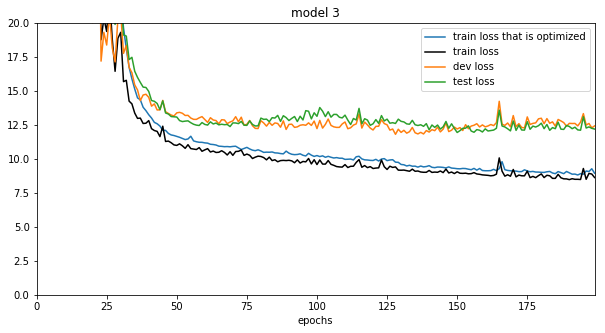

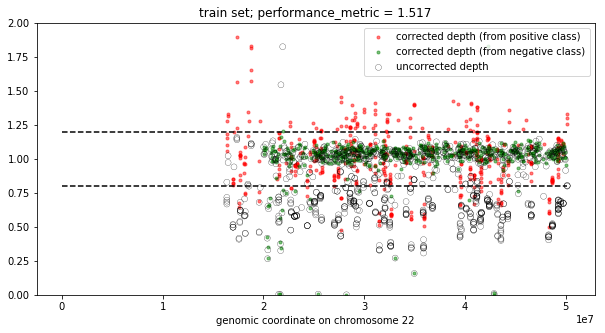

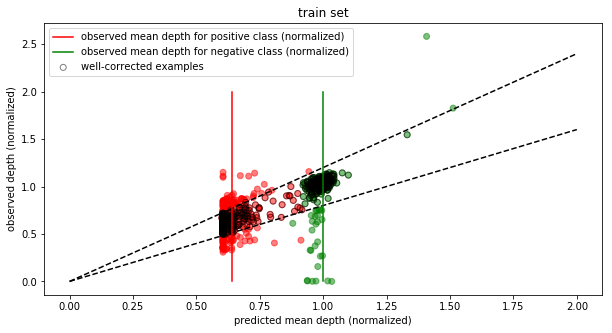

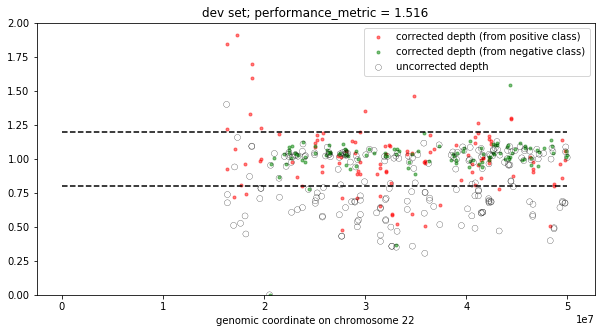

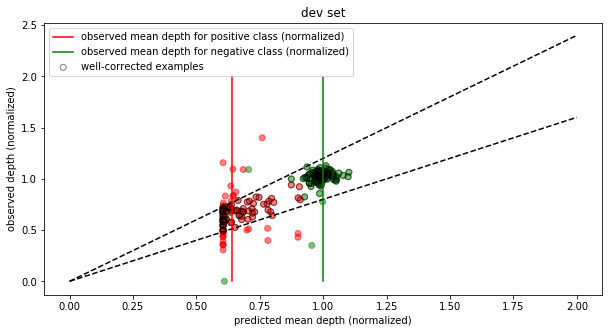

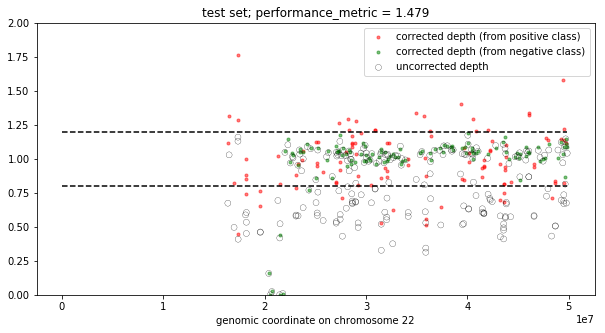

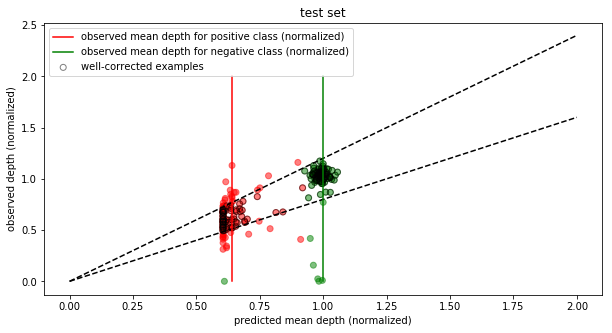

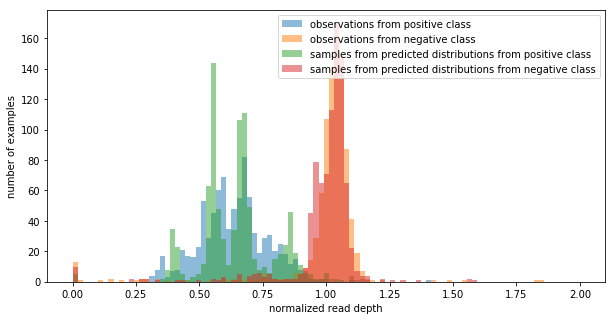

In [40]:
plot_history([('model 3', model_3_standard_history, model_3_custom_history)], loss_max=20)
evaluate_performance(data_train, 'train', model_3)
evaluate_performance(data_train, 'dev', model_3)
evaluate_performance(data_train, 'test', model_3)
plot_depth_distribution(data_train, model_3)

## Additional filters and additional dropout

In [12]:
def build_model_4(sequence_length, learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=20, 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)
    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    conv1_dropout = tfkl.Dropout(rate=0.25)(conv1)

    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1_dropout)
    conv2_dropout = tfkl.Dropout(rate=0.25)(conv2)

    flatten = tfkl.Flatten()(conv2_dropout)
    flatten_dropout = tfkl.Dropout(rate=0.25)(flatten)

    dense = tfkl.Dense(40, activation='relu')(flatten_dropout)
    dense_dropout = tfkl.Dropout(rate=0.25)(dense)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters, activation=None)(dense_dropout)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_4 = build_model_4(compute_sequence_length(data_test))

model_4_standard_history, model_4_custom_history = train(model_4, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_3:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_3/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 50)            4000      
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 50)             0         
_________________________________________________________________
flatt

Epoch 61/200
29/29 [==============================] - 2s 73ms/step - loss: 47.1762 - val_loss: 27.2787
Epoch 62/200
29/29 [==============================] - 2s 73ms/step - loss: 44.9303 - val_loss: 26.4882
Epoch 63/200
29/29 [==============================] - 2s 72ms/step - loss: 43.2219 - val_loss: 25.7229
Epoch 64/200
29/29 [==============================] - 2s 73ms/step - loss: 41.4510 - val_loss: 25.3720
Epoch 65/200
29/29 [==============================] - 2s 72ms/step - loss: 39.1929 - val_loss: 21.7214
Epoch 66/200
29/29 [==============================] - 2s 72ms/step - loss: 36.6991 - val_loss: 16.1440
Epoch 67/200
29/29 [==============================] - 2s 73ms/step - loss: 33.6658 - val_loss: 13.9076
Epoch 68/200
29/29 [==============================] - 2s 72ms/step - loss: 30.8047 - val_loss: 21.0396
Epoch 69/200
29/29 [==============================] - 2s 72ms/step - loss: 28.3665 - val_loss: 23.8860
Epoch 70/200
29/29 [==============================] - 2s 73ms/step - loss

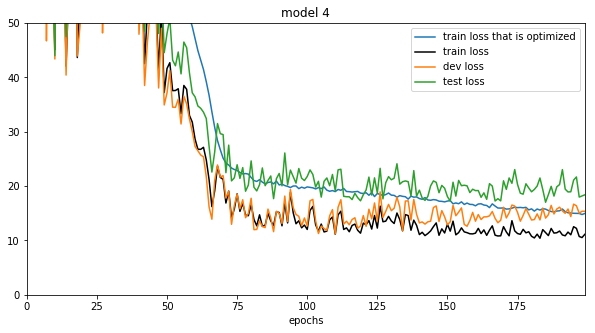

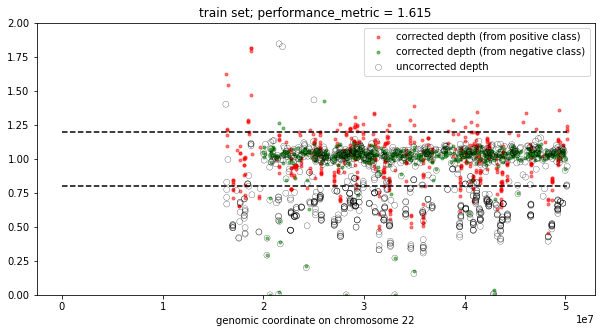

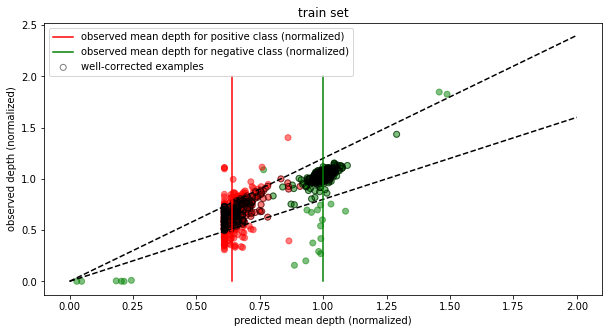

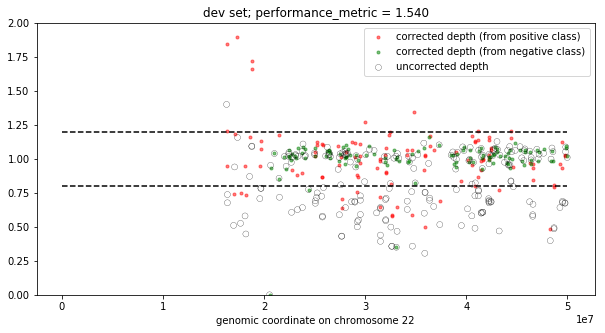

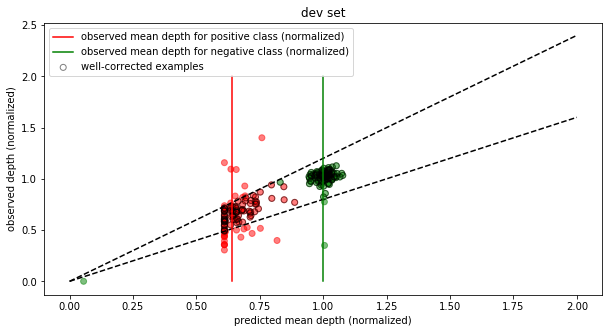

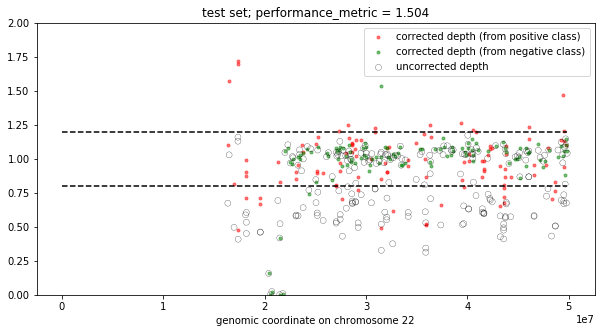

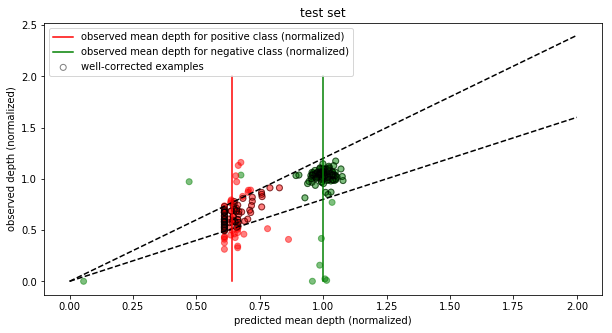

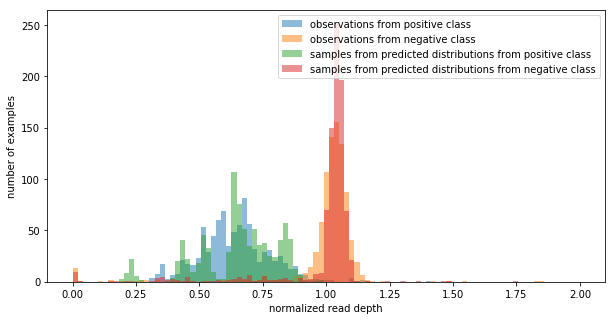

In [36]:
plot_history([('model 4', model_4_standard_history, model_4_custom_history)], loss_max=50)
evaluate_performance(data_train, 'train', model_4)
evaluate_performance(data_train, 'dev', model_4)
evaluate_performance(data_train, 'test', model_4)
plot_depth_distribution(data_train, model_4)


## Smaller learning rate

In [14]:
model_4_smallLearningRate = build_model_4(compute_sequence_length(data_test), learning_rate=0.002)

model_4_smallLearningRate_standard_history, model_4_smallLearningRate_custom_history = train(model_4_smallLearningRate, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_4:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_4/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 50)            4000      
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 50)             0         
_________________________________________________________________
flatt

29/29 [==============================] - 3s 103ms/step - loss: 79.7077 - val_loss: 40.5850
Epoch 139/200
29/29 [==============================] - 3s 100ms/step - loss: 79.3032 - val_loss: 55.6455
Epoch 140/200
29/29 [==============================] - 3s 98ms/step - loss: 81.6798 - val_loss: 29.1429
Epoch 141/200
29/29 [==============================] - 3s 102ms/step - loss: 82.8611 - val_loss: 28.3282
Epoch 142/200
29/29 [==============================] - 3s 106ms/step - loss: 76.8687 - val_loss: 27.2498
Epoch 143/200
29/29 [==============================] - 3s 108ms/step - loss: 74.7698 - val_loss: 28.0325
Epoch 144/200
29/29 [==============================] - 3s 106ms/step - loss: 77.5584 - val_loss: 41.4968
Epoch 145/200
29/29 [==============================] - 3s 100ms/step - loss: 75.2766 - val_loss: 23.2765
Epoch 146/200
29/29 [==============================] - 3s 102ms/step - loss: 74.4657 - val_loss: 21.6539
Epoch 147/200
29/29 [==============================] - 3s 102ms/step -

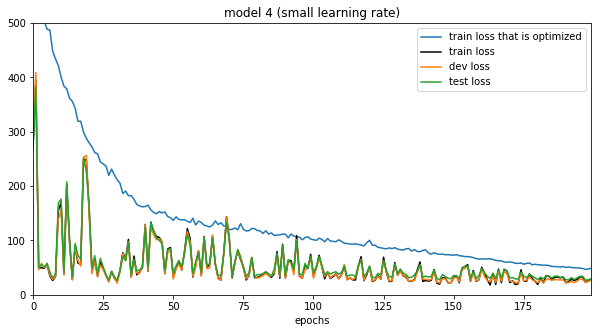

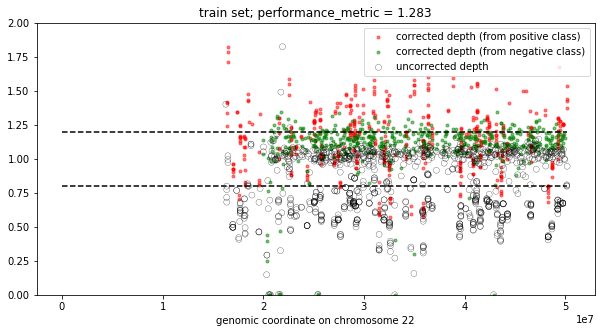

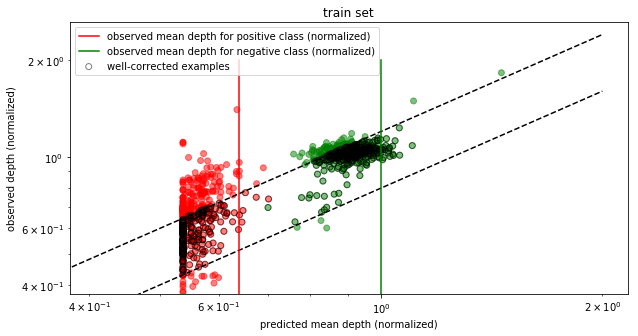

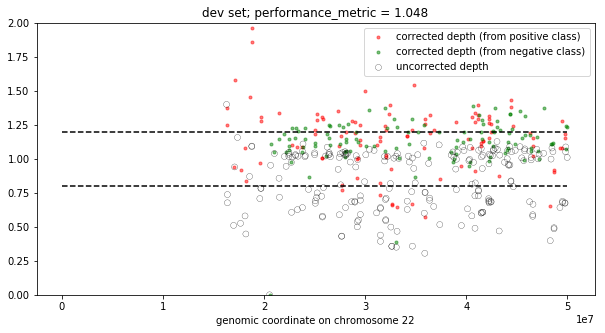

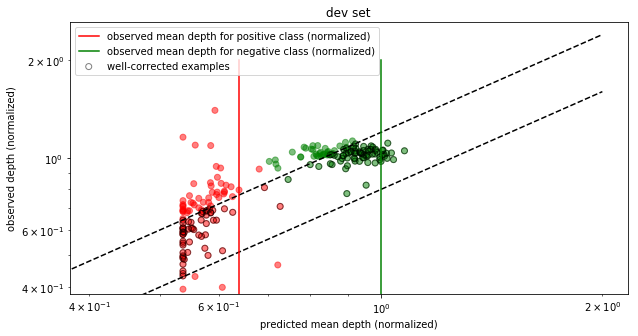

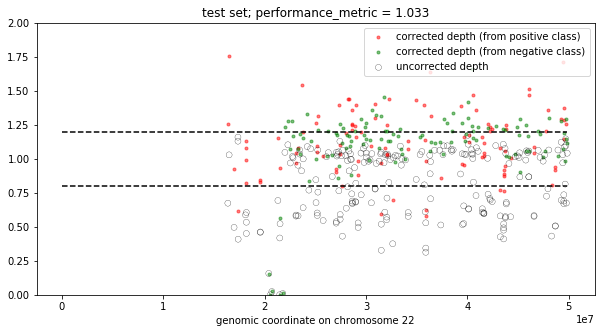

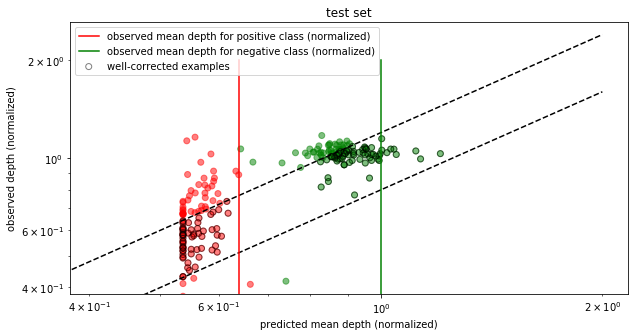

In [15]:
plot_history([('model 4 (small learning rate)', model_4_smallLearningRate_standard_history, model_4_smallLearningRate_custom_history)], loss_max=500)
evaluate_performance(data_train, 'train', model_4_smallLearningRate)
evaluate_performance(data_train, 'dev', model_4_smallLearningRate)
evaluate_performance(data_train, 'test', model_4_smallLearningRate)


## Add pooling

In [16]:
def build_model_5(sequence_length, learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=8, 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)
    conv1 = tfkl.MaxPooling1D(pool_size=2)(conv1)
    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    conv1 = tfkl.Dropout(rate=0.25)(conv1)
    
    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1)
    conv2 = tfkl.MaxPooling1D(pool_size=2)(conv2)
    conv2 = tfkl.Dropout(rate=0.25)(conv2)

    flatten = tfkl.Flatten()(conv2)
    flatten = tfkl.Dropout(rate=0.25)(flatten)

    dense = tfkl.Dense(40, activation='relu')(flatten)
    dense = tfkl.Dropout(rate=0.25)(dense)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters, activation=None)(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    tfk = tf.keras
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_5 = build_model_5(compute_sequence_length(data_test))

model_5_standard_history, model_5_custom_history = train(model_5, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_5:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_5/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 50)            1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
max_p

29/29 [==============================] - 3s 116ms/step - loss: 17.2853 - val_loss: 17.0839
Epoch 136/200
29/29 [==============================] - 4s 122ms/step - loss: 16.9167 - val_loss: 17.7274
Epoch 137/200
29/29 [==============================] - 3s 119ms/step - loss: 16.3975 - val_loss: 16.3992
Epoch 138/200
29/29 [==============================] - 3s 109ms/step - loss: 16.2357 - val_loss: 16.4485
Epoch 139/200
29/29 [==============================] - 3s 112ms/step - loss: 15.8119 - val_loss: 16.4121
Epoch 140/200
29/29 [==============================] - 3s 116ms/step - loss: 15.6105 - val_loss: 16.5209
Epoch 141/200
29/29 [==============================] - 3s 115ms/step - loss: 15.3700 - val_loss: 16.3091
Epoch 142/200
29/29 [==============================] - 3s 115ms/step - loss: 15.0539 - val_loss: 15.7082
Epoch 143/200
29/29 [==============================] - 4s 127ms/step - loss: 14.9833 - val_loss: 15.9538
Epoch 144/200
29/29 [==============================] - 4s 129ms/step 

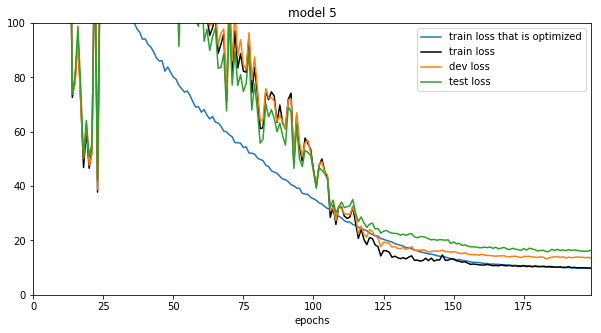

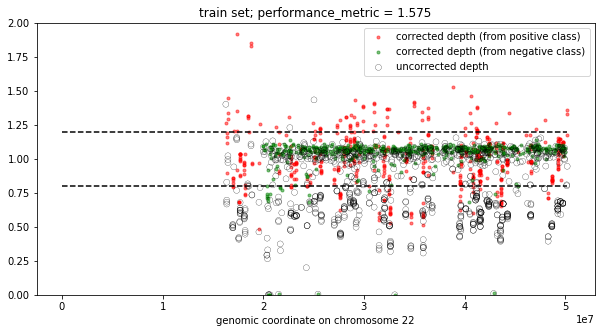

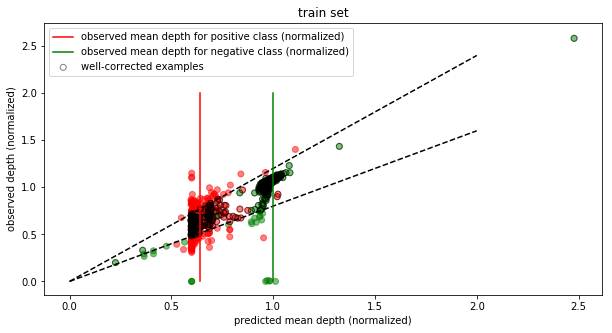

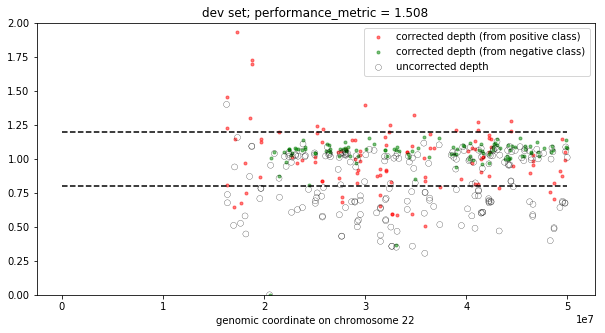

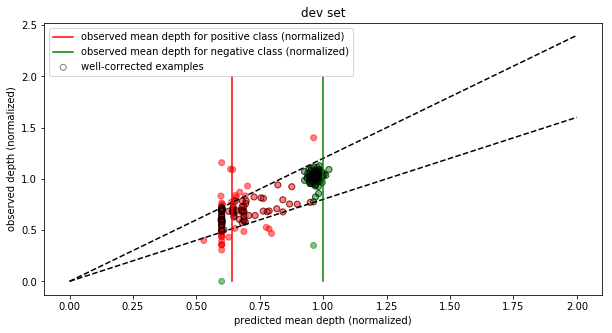

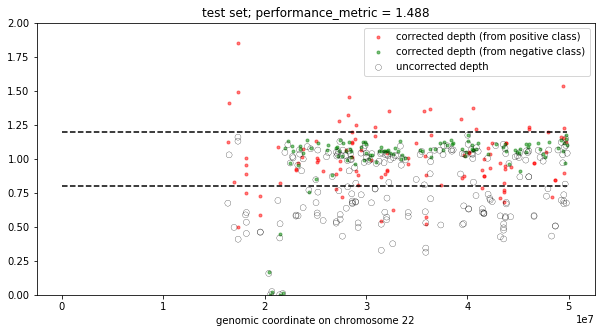

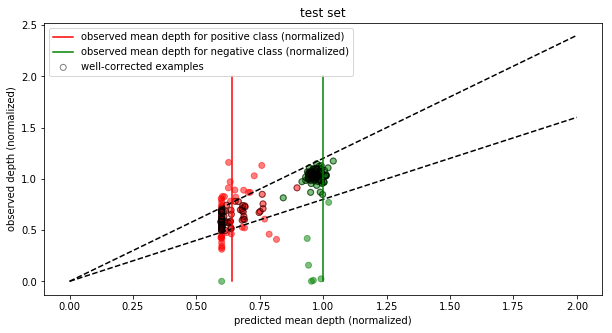

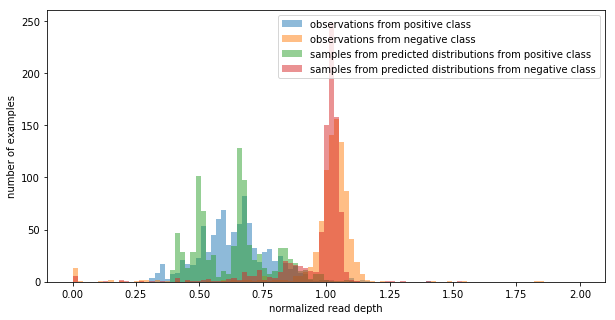

In [37]:
plot_history([('model 5', model_5_standard_history, model_5_custom_history)], loss_max=100)
evaluate_performance(data_train, 'train', model_5)
evaluate_performance(data_train, 'dev', model_5)
evaluate_performance(data_train, 'test', model_5)
plot_depth_distribution(data_train, model_5)


## Add strong L2 regularization

In [18]:
def build_model_6(sequence_length, learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers
    tfk = tf.keras

    inputs = tfkl.Input(shape=(sequence_length, 4))

    regularization_strength = 0.1
    
    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=8, 
        use_bias=False,
        padding='valid',
        activation='relu',
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(inputs)
    conv1 = tfkl.MaxPooling1D(pool_size=2)(conv1)
    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    conv1 = tfkl.Dropout(rate=0.25)(conv1)
    
    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu',
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(conv1)
    conv2 = tfkl.MaxPooling1D(pool_size=2)(conv2)
    conv2 = tfkl.Dropout(rate=0.25)(conv2)

    flatten = tfkl.Flatten()(conv2)
    flatten = tfkl.Dropout(rate=0.25)(flatten)

    dense = tfkl.Dense(40, activation='relu', kernel_regularizer=tfk.regularizers.l2(regularization_strength))(flatten)
    dense = tfkl.Dropout(rate=0.25)(dense)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(
        number_distribution_parameters, 
        activation=None,
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_6 = build_model_6(compute_sequence_length(data_test))

model_6_standard_history, model_6_custom_history = train(model_6, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_6:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_6/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 50)            1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
max_p

29/29 [==============================] - 3s 117ms/step - loss: 17.9617 - val_loss: 21.2480
Epoch 136/200
29/29 [==============================] - 3s 117ms/step - loss: 17.8959 - val_loss: 24.1737
Epoch 137/200
29/29 [==============================] - 3s 119ms/step - loss: 17.3534 - val_loss: 22.6579
Epoch 138/200
29/29 [==============================] - 4s 124ms/step - loss: 17.7256 - val_loss: 22.2600
Epoch 139/200
29/29 [==============================] - 3s 118ms/step - loss: 17.3515 - val_loss: 23.3074
Epoch 140/200
29/29 [==============================] - 3s 117ms/step - loss: 17.3797 - val_loss: 22.4296
Epoch 141/200
29/29 [==============================] - 4s 129ms/step - loss: 17.3729 - val_loss: 22.1330
Epoch 142/200
29/29 [==============================] - 4s 138ms/step - loss: 16.9684 - val_loss: 21.6911
Epoch 143/200
29/29 [==============================] - 3s 119ms/step - loss: 17.2828 - val_loss: 21.7874
Epoch 144/200
29/29 [==============================] - 4s 126ms/step 

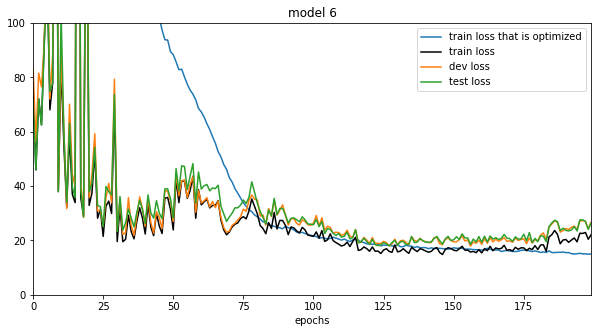

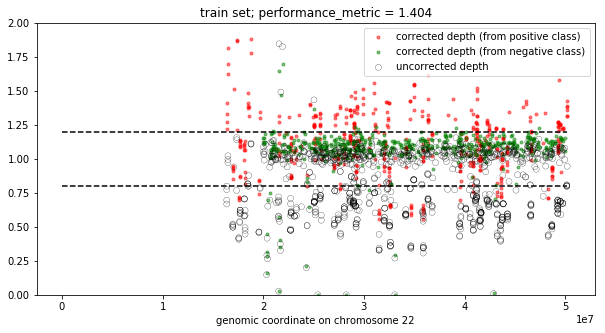

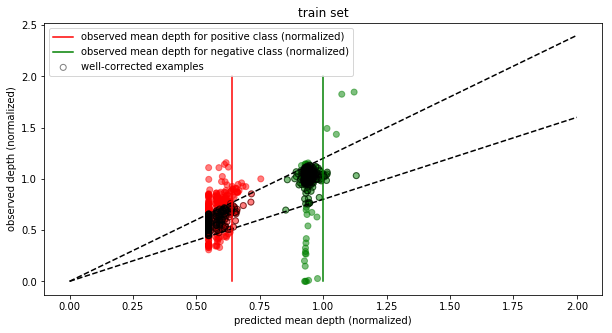

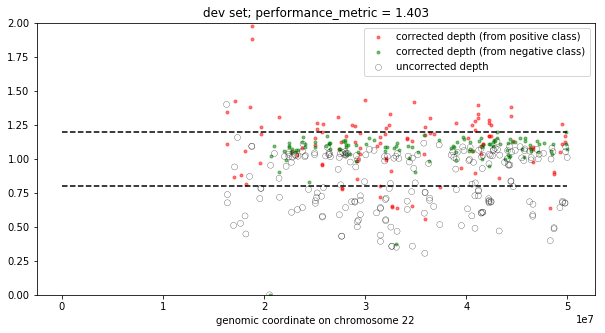

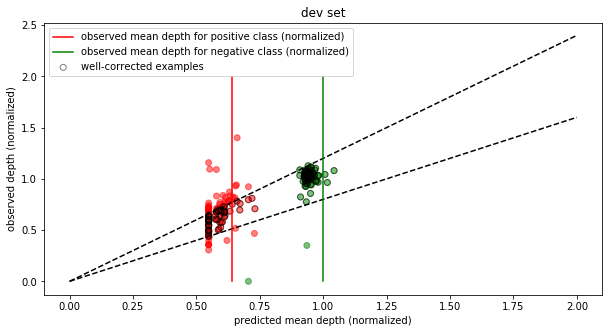

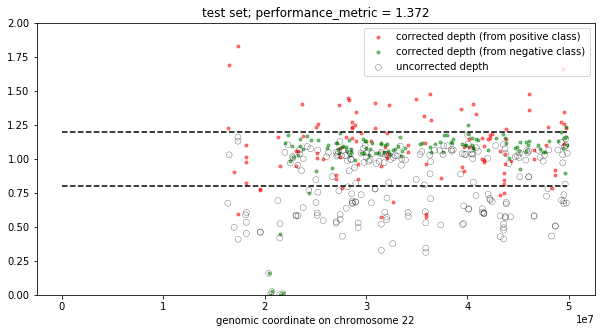

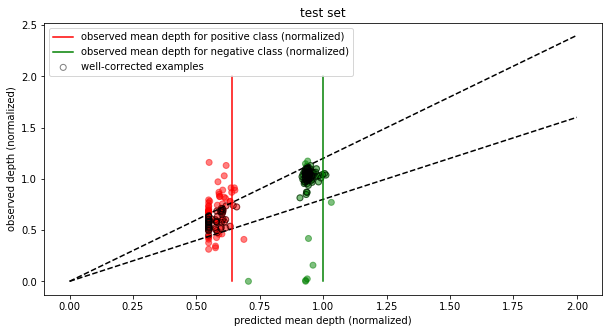

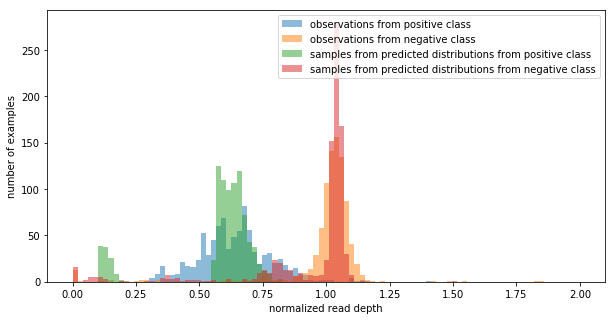

In [38]:
plot_history([('model 6', model_6_standard_history, model_6_custom_history)], loss_max=100)
evaluate_performance(data_train, 'train', model_6)
evaluate_performance(data_train, 'dev', model_6)
evaluate_performance(data_train, 'test', model_6)
plot_depth_distribution(data_train, model_6)



## Add weak L2 regularization

In [20]:
def build_model_7(sequence_length, learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers
    tfk = tf.keras

    inputs = tfkl.Input(shape=(sequence_length, 4))

    regularization_strength = 0.01
    
    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=8, 
        use_bias=False,
        padding='valid',
        activation='relu',
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(inputs)
    conv1 = tfkl.MaxPooling1D(pool_size=2)(conv1)
    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    conv1 = tfkl.Dropout(rate=0.25)(conv1)
    
    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu',
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(conv1)
    conv2 = tfkl.MaxPooling1D(pool_size=2)(conv2)
    conv2 = tfkl.Dropout(rate=0.25)(conv2)

    flatten = tfkl.Flatten()(conv2)
    flatten = tfkl.Dropout(rate=0.25)(flatten)

    dense = tfkl.Dense(40, activation='relu', kernel_regularizer=tfk.regularizers.l2(regularization_strength))(flatten)
    dense = tfkl.Dropout(rate=0.25)(dense)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(
        number_distribution_parameters, 
        activation=None,
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_7 = build_model_7(compute_sequence_length(data_test))

model_7_standard_history, model_7_custom_history = train(model_7, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_7:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_7/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 23, 50)            1600      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 50)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
max_p

29/29 [==============================] - 4s 127ms/step - loss: 18.7020 - val_loss: 12.3591
Epoch 136/200
29/29 [==============================] - 4s 126ms/step - loss: 18.6032 - val_loss: 13.8880
Epoch 137/200
29/29 [==============================] - 4s 127ms/step - loss: 18.6345 - val_loss: 14.1150
Epoch 138/200
29/29 [==============================] - 4s 127ms/step - loss: 18.6054 - val_loss: 14.2439
Epoch 139/200
29/29 [==============================] - 4s 127ms/step - loss: 18.6653 - val_loss: 12.2879
Epoch 140/200
29/29 [==============================] - 4s 127ms/step - loss: 18.2917 - val_loss: 12.9718
Epoch 141/200
29/29 [==============================] - 4s 129ms/step - loss: 18.4366 - val_loss: 13.8363
Epoch 142/200
29/29 [==============================] - 4s 128ms/step - loss: 17.9191 - val_loss: 13.4120
Epoch 143/200
29/29 [==============================] - 4s 128ms/step - loss: 17.8542 - val_loss: 13.0225
Epoch 144/200
29/29 [==============================] - 4s 133ms/step 

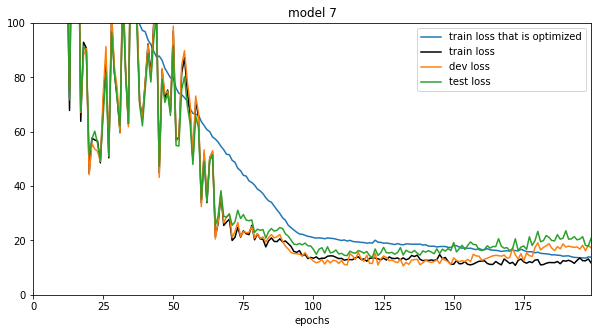

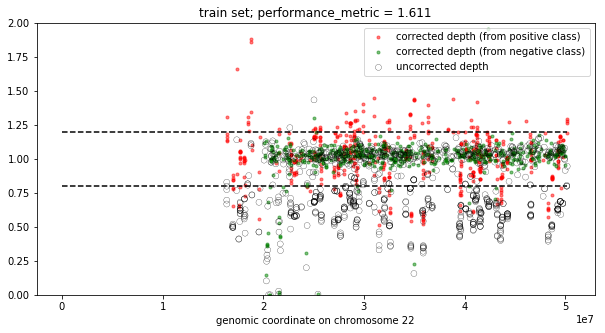

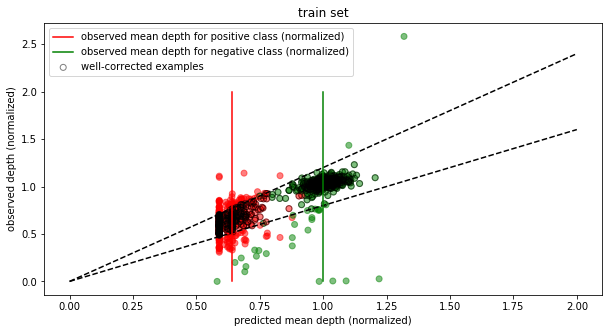

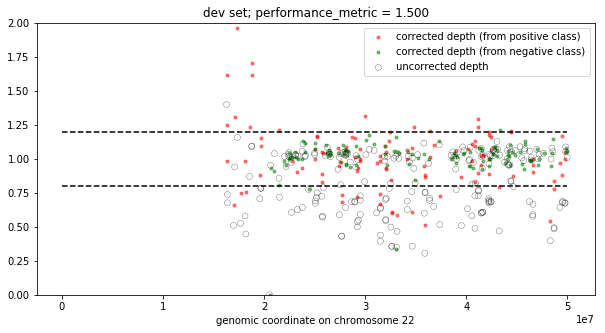

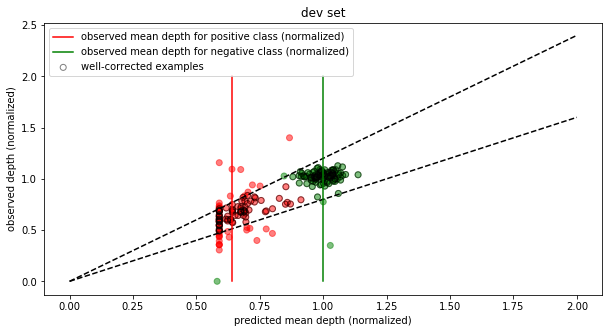

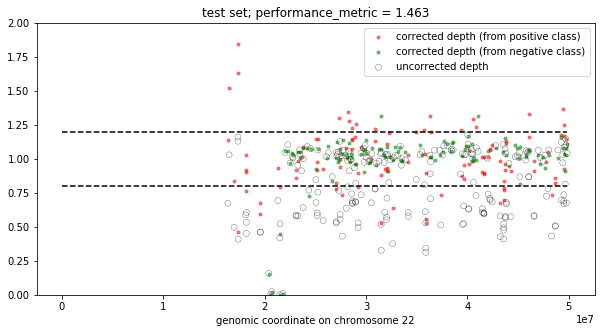

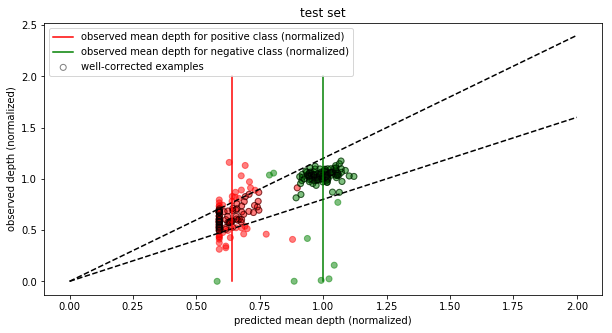

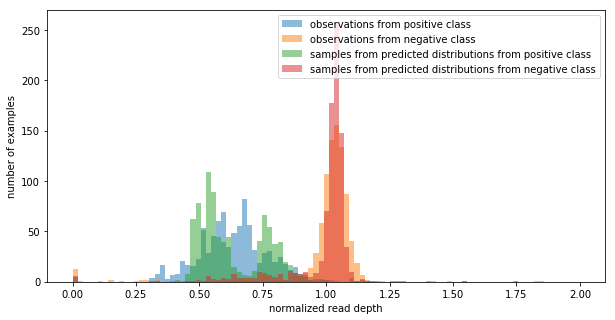

In [39]:
plot_history([('model 7', model_7_standard_history, model_7_custom_history)], loss_max=100)
evaluate_performance(data_train, 'train', model_7)
evaluate_performance(data_train, 'dev', model_7)
evaluate_performance(data_train, 'test', model_7)
plot_depth_distribution(data_train, model_7)


## Larger number of Poisson components

If there are too many Poisson components, then the model can match the entire distribution of depths (from both classes) with a single mixture distribution, instead of predicting two mixture distributions, one for each class. Thus, there is a sweet spot: too few Poisson components, and we cannot account for sequence-independent biases; too many Poisson components, and we cannot resolve individual classes. 

In [22]:
def build_model_8(sequence_length, learning_rate=0.0025):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers
    tfk = tf.keras

    inputs = tfkl.Input(shape=(sequence_length, 4))

    regularization_strength = 0.05
    
    conv1 = tfkl.Conv1D(
        filters=10, 
        kernel_size=20, 
        padding='valid',
        activation='relu',
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)        
    )(inputs)
    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    conv1 = tfkl.Dropout(rate=0.4)(conv1)
    
    conv2 = tfkl.Conv1D(
        filters=10, 
        kernel_size=6, 
        padding='valid',
        activation='relu',
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)        
    )(conv1)
    conv2 = tfkl.Dropout(rate=0.4)(conv2)

    flatten = tfkl.Flatten()(conv2)

    dense = tfkl.Dense(40, activation='relu', kernel_regularizer=tfk.regularizers.l2(regularization_strength))(flatten)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 20
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(
        number_distribution_parameters,
        activation=None,
        kernel_regularizer=tfk.regularizers.l2(regularization_strength)
    )(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_8 = build_model_8(compute_sequence_length(data_test))

model_8_standard_history, model_8_custom_history = train(model_8, data_train, data_dev, data_test, number_epochs=300) 


inputs [<tf.Tensor 'input_1_8:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_8/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 10)            810       
_________________________________________________________________
dropout (Dropout)            (None, 11, 10)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 10)             610       
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 10)             0         
_________________________________________________________________
flatt

Epoch 64/300
29/29 [==============================] - 3s 89ms/step - loss: 26.1464 - val_loss: 17.7182
Epoch 65/300
29/29 [==============================] - 3s 88ms/step - loss: 25.7592 - val_loss: 22.1771
Epoch 66/300
29/29 [==============================] - 3s 92ms/step - loss: 24.3477 - val_loss: 19.8100
Epoch 67/300
29/29 [==============================] - 3s 89ms/step - loss: 24.0638 - val_loss: 17.9765
Epoch 68/300
29/29 [==============================] - 3s 89ms/step - loss: 23.8487 - val_loss: 20.1629
Epoch 69/300
29/29 [==============================] - 3s 88ms/step - loss: 22.5960 - val_loss: 17.6888
Epoch 70/300
29/29 [==============================] - 3s 92ms/step - loss: 22.0537 - val_loss: 18.3108
Epoch 71/300
29/29 [==============================] - 3s 92ms/step - loss: 21.5424 - val_loss: 16.9063
Epoch 72/300
29/29 [==============================] - 3s 94ms/step - loss: 21.0300 - val_loss: 15.5754
Epoch 73/300
29/29 [==============================] - 3s 92ms/step - loss

29/29 [==============================] - 3s 95ms/step - loss: 11.0018 - val_loss: 10.6453
Epoch 144/300
29/29 [==============================] - 3s 95ms/step - loss: 10.9834 - val_loss: 10.6334
Epoch 145/300
29/29 [==============================] - 3s 91ms/step - loss: 11.0528 - val_loss: 10.5976
Epoch 146/300
29/29 [==============================] - 3s 91ms/step - loss: 11.0082 - val_loss: 10.6245
Epoch 147/300
29/29 [==============================] - 3s 89ms/step - loss: 10.9146 - val_loss: 10.6268
Epoch 148/300
29/29 [==============================] - 3s 92ms/step - loss: 10.8750 - val_loss: 10.4848
Epoch 149/300
29/29 [==============================] - 3s 104ms/step - loss: 10.8829 - val_loss: 10.6406
Epoch 150/300
29/29 [==============================] - 3s 95ms/step - loss: 10.8752 - val_loss: 10.5884
Epoch 151/300
29/29 [==============================] - 3s 98ms/step - loss: 10.8801 - val_loss: 10.5564
Epoch 152/300
29/29 [==============================] - 3s 92ms/step - loss: 1

29/29 [==============================] - 3s 110ms/step - loss: 8.9952 - val_loss: 8.9529


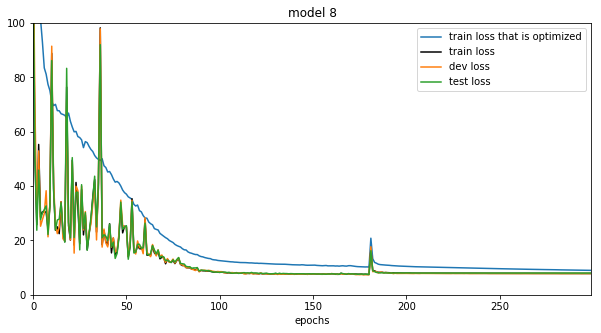

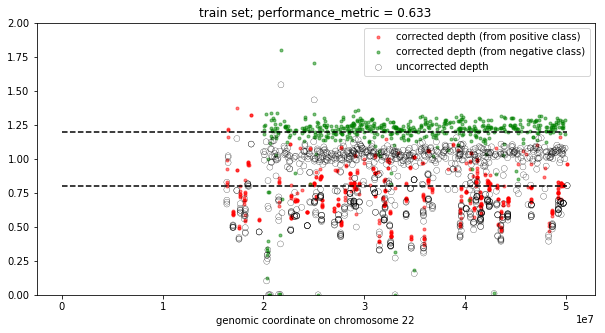

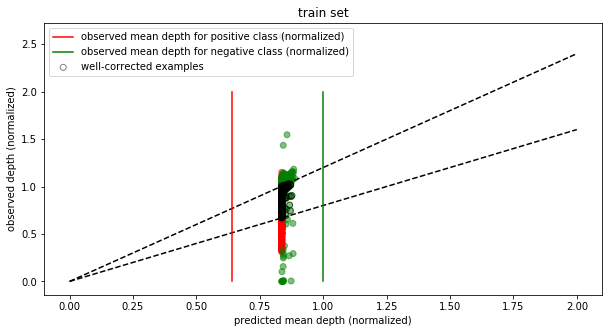

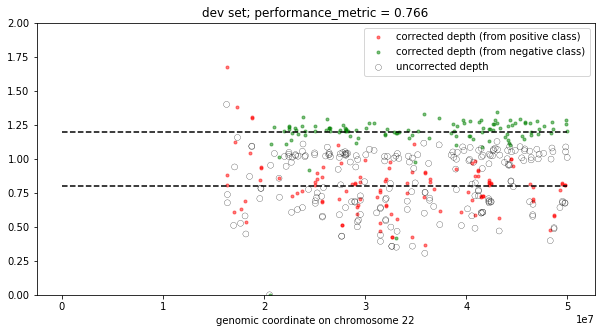

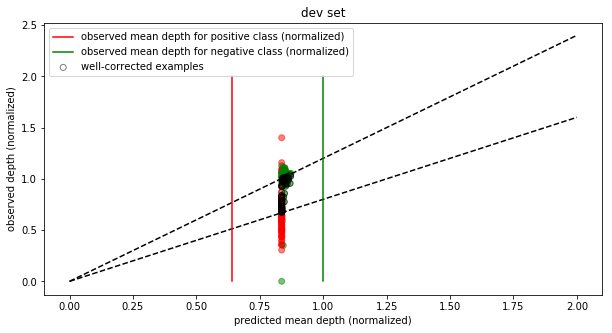

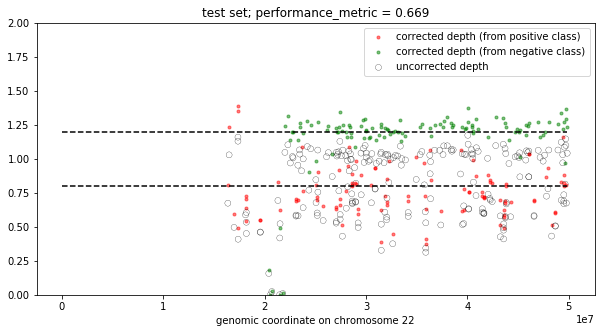

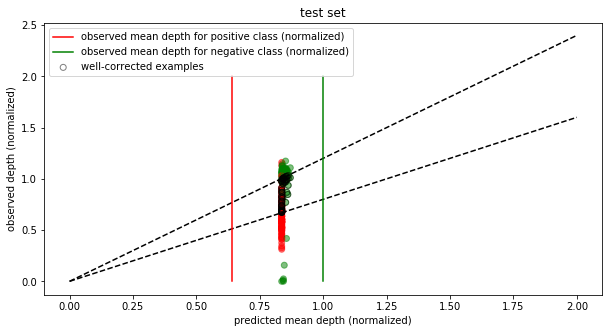

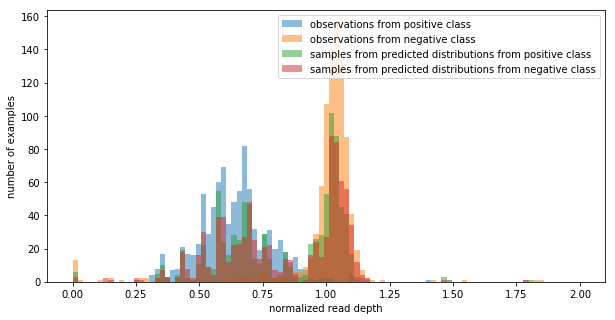

In [32]:
plot_history([('model 8', model_8_standard_history, model_8_custom_history)], loss_max=100)
evaluate_performance(data_train, 'train', model_8)
evaluate_performance(data_train, 'dev', model_8)
evaluate_performance(data_train, 'test', model_8)
plot_depth_distribution(data_train, model_8)


## model 4: increase dropout rate and add weak L2 regularization

In [23]:
def build_model_4_weakL2(sequence_length, learning_rate=0.01):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    regularization_strength = 0.01

    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=20, 
        use_bias=False,
        padding='valid',
        activation='relu')(inputs)
    # INVERTED DROPOUT
    # "Dropout" gets applied to the output of preceding layer (at training time only):
    # https://keras.io/layers/core/#dropout
    # weights are scaled by inverse of dropout rate (at training time only):
    # see: line 2263 of /anaconda2/envs/tensorflow3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py
    # also see: https://github.com/keras-team/keras/issues/3305#issuecomment-235359883
    # also see: https://www.coursera.org/lecture/deep-neural-network/dropout-regularization-eM33A
    conv1 = tfkl.Dropout(rate=0.4)(conv1)

    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation='relu')(conv1)
    conv2 = tfkl.Dropout(rate=0.4)(conv2)

    flatten = tfkl.Flatten()(conv2)
    flatten = tfkl.Dropout(rate=0.4)(flatten)

    tfk = tf.keras
    dense = tfkl.Dense(40, activation='relu', kernel_regularizer=tfk.regularizers.l2(regularization_strength))(flatten)
    dense = tfkl.Dropout(rate=0.25)(dense)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(number_distribution_parameters, activation=None)(dense)

    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)

    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_4_weakL2 = build_model_4_weakL2(compute_sequence_length(data_test))

model_4_weakL2_standard_history, model_4_weakL2_custom_history = train(model_4_weakL2, data_train, data_dev, data_test, number_epochs=200) 


inputs [<tf.Tensor 'input_1_11:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_11/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 50)            4000      
_________________________________________________________________
dropout (Dropout)            (None, 11, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 50)             15000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 50)             0         
_________________________________________________________________
fla

29/29 [==============================] - 4s 133ms/step - loss: 15.8531 - val_loss: 16.9866
Epoch 139/200
29/29 [==============================] - 4s 139ms/step - loss: 15.1834 - val_loss: 16.6341
Epoch 140/200
29/29 [==============================] - 4s 129ms/step - loss: 15.1510 - val_loss: 17.0864
Epoch 141/200
29/29 [==============================] - 4s 129ms/step - loss: 15.2607 - val_loss: 15.3937
Epoch 142/200
29/29 [==============================] - 4s 134ms/step - loss: 15.1263 - val_loss: 16.9388
Epoch 143/200
29/29 [==============================] - 4s 142ms/step - loss: 15.1482 - val_loss: 16.8854
Epoch 144/200
29/29 [==============================] - 4s 132ms/step - loss: 14.7896 - val_loss: 16.4533
Epoch 145/200
29/29 [==============================] - 4s 130ms/step - loss: 14.9759 - val_loss: 15.2674
Epoch 146/200
29/29 [==============================] - 4s 128ms/step - loss: 14.8070 - val_loss: 16.2639
Epoch 147/200
29/29 [==============================] - 4s 134ms/step 

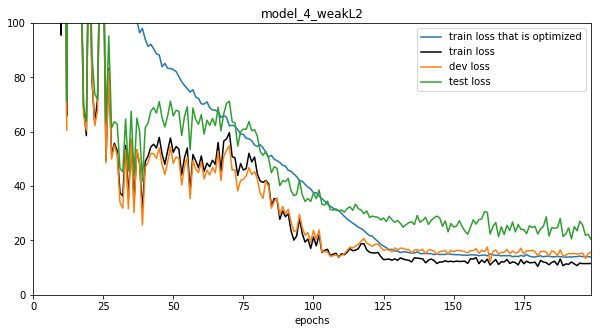

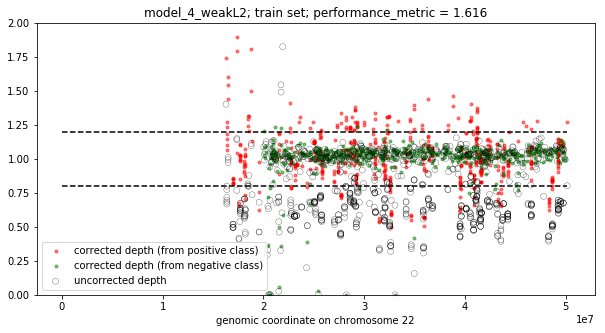

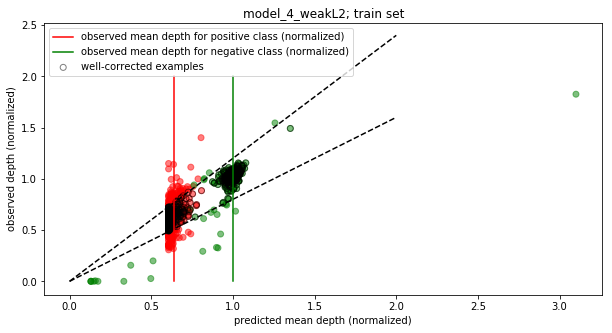

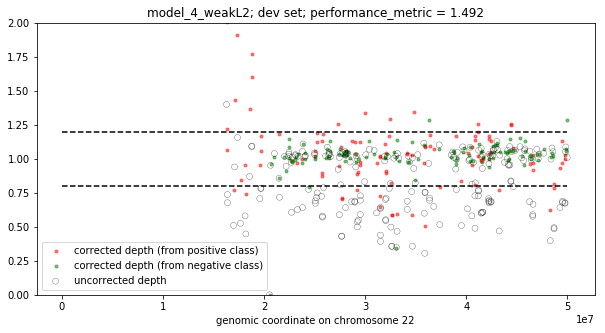

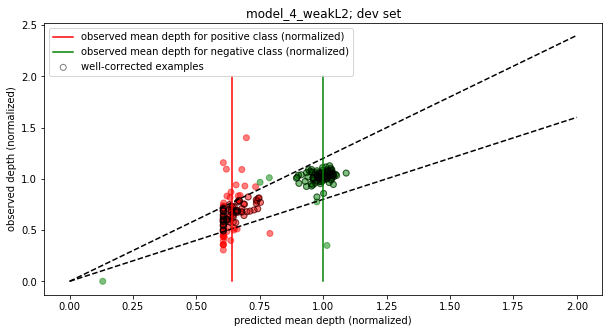

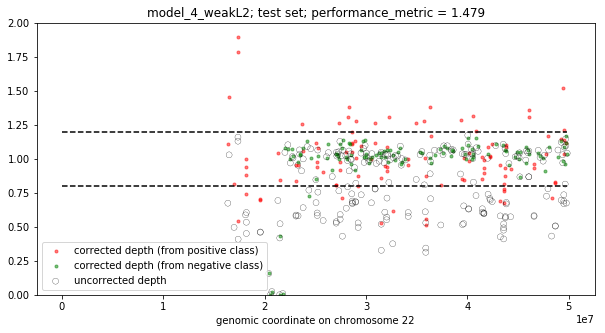

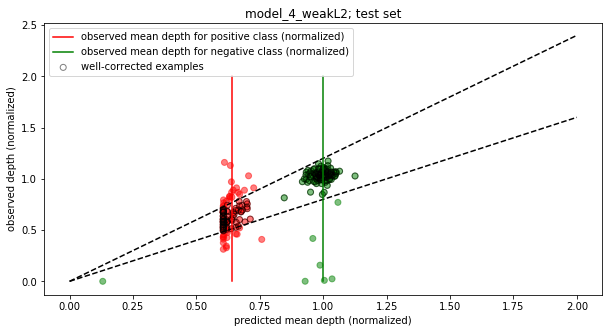

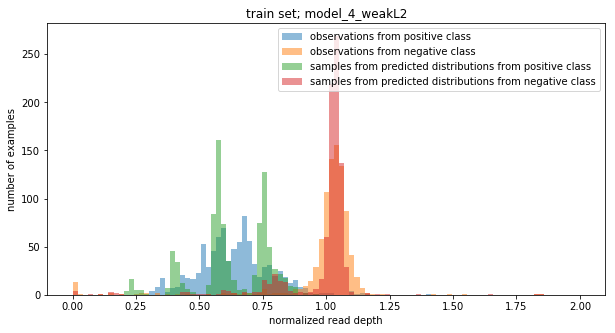

In [48]:
plot_history([('model_4_weakL2', model_4_weakL2_standard_history, model_4_weakL2_custom_history)], loss_max=100)
evaluate_performance('model_4_weakL2', data_train, 'train', model_4_weakL2)
evaluate_performance('model_4_weakL2', data_train, 'dev', model_4_weakL2)
evaluate_performance('model_4_weakL2', data_train, 'test', model_4_weakL2)
plot_depth_distribution('train', model_4_weakL2, 'model_4_weakL2')


## Batch normalization

Batch normalization can make a model train faster, but doesn’t necessarily make the model more accurate: 


In [72]:
def build_model_9(sequence_length, learning_rate=0.02):
    # https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
    clear_session() 

    tfkl = tf.keras.layers

    inputs = tfkl.Input(shape=(sequence_length, 4))

    batch_norm_regularization_strength = 0.01
#     dense_regularization_strength = 0.01 
    dense_regularization_strength = 0.005 
    
    tfk = tf.keras

    conv1 = tfkl.Conv1D(
        filters=50, 
        kernel_size=20, 
        use_bias=False,
        padding='valid',
        activation=None)(inputs)
    # https://stackoverflow.com/questions/38553927/batch-normalization-in-convolutional-neural-network
    conv1 = tfkl.BatchNormalization(
        beta_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength),
        gamma_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength)
    )(conv1)
    conv1 = tfkl.Activation('relu')(conv1)
#     conv1 = tfkl.Dropout(rate=0.4)(conv1)
    conv1 = tfkl.Dropout(rate=0.2)(conv1)

    conv2 = tfkl.Conv1D(
        filters=50, 
        kernel_size=6, 
        use_bias=False,
        padding='valid',
        activation=None)(conv1)
    conv2 = tfkl.BatchNormalization(
        beta_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength),
        gamma_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength)
    )(conv2)
    conv2 = tfkl.Activation('relu')(conv2)
#     conv2 = tfkl.Dropout(rate=0.4)(conv2)
    conv2 = tfkl.Dropout(rate=0.2)(conv2)

    flatten = tfkl.Flatten()(conv2)
    flatten = tfkl.Dropout(rate=0.4)(flatten)

    dense = tfkl.Dense(
        40, 
        activation=None,
        use_bias=False,
        kernel_regularizer=tfk.regularizers.l2(dense_regularization_strength)
    )(flatten)
    dense = tfkl.BatchNormalization(
        beta_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength),
        gamma_regularizer=tfk.regularizers.l2(batch_norm_regularization_strength)
    )(dense)
    dense = tfkl.Activation('relu')(dense)
#     dense = tfkl.Dropout(rate=0.5)(dense)
    dense = tfkl.Dropout(rate=0.2)(dense)

    tfpl = tfp.layers

    # https://en.wikipedia.org/wiki/Mixture_distribution
    # https://en.wikipedia.org/wiki/Compound_probability_distribution
    # https://groups.google.com/a/tensorflow.org/forum/#!topic/tfprobability/YfzNLYavOyU
    number_components = 5
    output_shape = (1,)
    number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
        number_components,
        tfpl.IndependentPoisson.params_size(output_shape))

    distribution_parameters = tfkl.Dense(
        number_distribution_parameters, 
        activation=None
    )(dense)

    print('...._output_shape: {}'.format(
        tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))._output_shape))
    
    outputs = tfpl.MixtureSameFamily(number_components, tfpl.IndependentPoisson(output_shape))(distribution_parameters)
    print(outputs)
    
    model_ = tfk.Model(inputs=inputs, outputs=outputs)

    model_.compile(
        optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate),
        loss=lambda y, d: -d.log_prob(y))

    print('inputs', model_.inputs)
    print('outputs', model_.outputs)
    model_.summary()
    
    return model_

model_9 = build_model_9(compute_sequence_length(data_test))

model_9_standard_history, model_9_custom_history = train(model_9, data_train, data_dev, data_test, number_epochs=2) 


...._output_shape: None
tfp.distributions.MixtureSameFamily("MixtureSameFamily_3/MixtureSameFamily/", batch_shape=(?,), event_shape=(1,), dtype=float32)
inputs [<tf.Tensor 'input_1_3:0' shape=(?, 30, 4) dtype=float32>]
outputs [<tfp.distributions.MixtureSameFamily 'MixtureSameFamily_3/MixtureSameFamily/' batch_shape=(?,) event_shape=(1,) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 4)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 50)            4000      
_________________________________________________________________
batch_normalization_v1 (Batc (None, 11, 50)            200       
_________________________________________________________________
activation (Activation)      (None, 11, 50)            0         
__________________________________________________

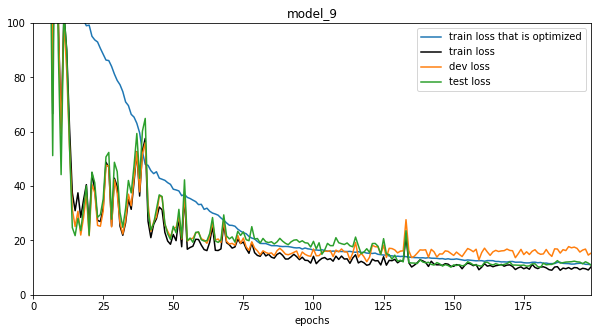

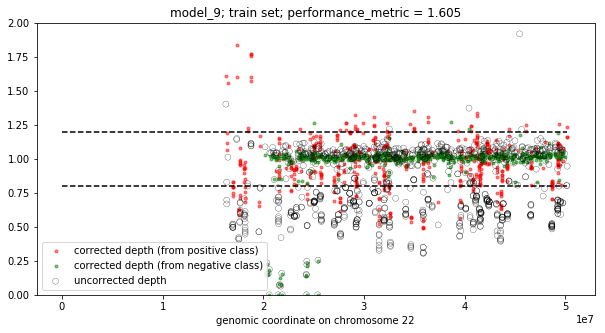

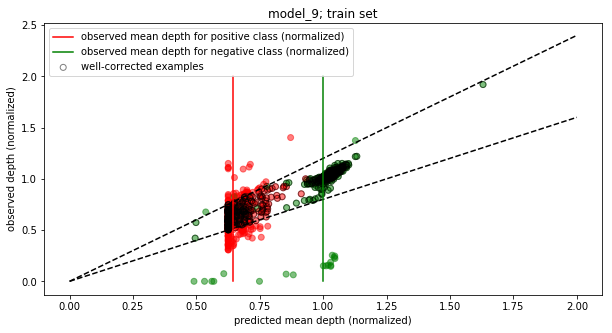

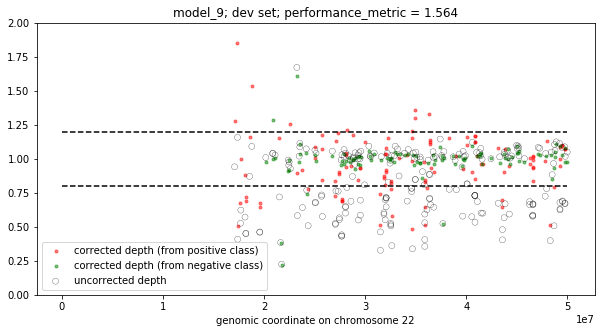

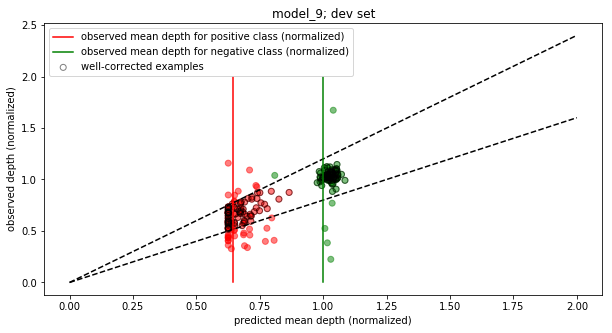

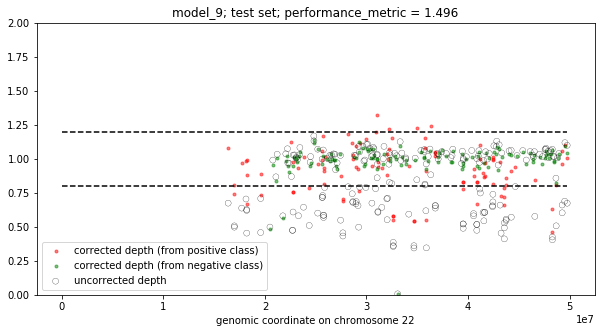

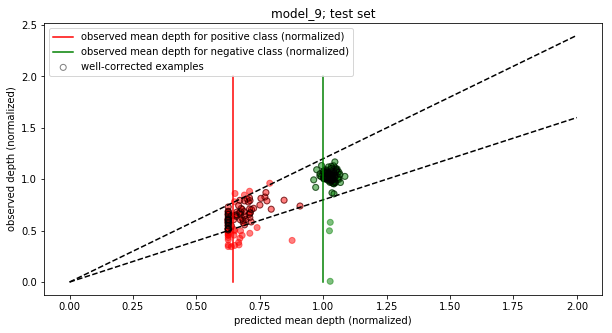

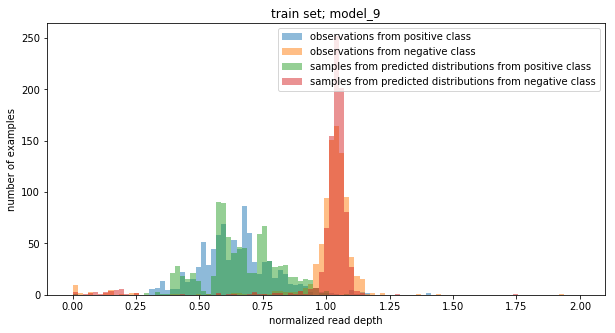

In [57]:
plot_history([('model_9', model_9_standard_history, model_9_custom_history)], loss_max=100)
evaluate_performance('model_9', data_train, 'train', model_9)
evaluate_performance('model_9', data_train, 'dev', model_9)
evaluate_performance('model_9', data_train, 'test', model_9)
plot_depth_distribution('train', model_9, 'model_9')


## To Do

* Is it easier to recover a sequence motif from the learned convolution filters when there are more Poisson components?
* Repeat for the CCCGCC motif, which is known to reduce read depth: [Ekblom et al 2014](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-15-467) and [Van den Hoecke et al 2016](https://www.nature.com/articles/srep26314). 
